In [1]:
include("smc_model.jl")
include("smc_model_parameters.jl")
using DifferentialEquations
using Plots
gr()
using DataFrames

q0 = Control_params();
p0 = Fixed_params();
s0 = State();

In [2]:
q0_dict = type2dict(q0);
s0_dict = type2dict(s0);

delete!(q0_dict,Symbol("g_leak_mit"));
q0_dict[Symbol("k_leak_er")] = 0.0;
#q0_dict[Symbol("g_leak_ecs")] = 0.0;
delete!(q0_dict,Symbol("g_leak_ecs"));

delete!(q0_dict,Symbol("SERCA"));
#delete!(q0_dict,Symbol("Qpmca"));
q0_dict[Symbol("Qryr")]  = .2;
q0_dict[Symbol("SERCA_s")]  = 100;
q0_dict[Symbol("Qip3r")]  = 2000;
q0_dict[Symbol("MyoTot")] = 10.0;
q0_dict[Symbol("Vnclx")] *= 5;
q0_dict[Symbol("Qpmca")] *= 1000;
q0_dict[Symbol("kncx2")] *= 100
q0_dict[Symbol("Qvocc")] *= 1000;
q0_dict[Symbol("L")] = 0.0;


delete!(s0_dict,Symbol("IP3"));
delete!(s0_dict,Symbol("IP3RX00"));
delete!(s0_dict,Symbol("IP3RX10"));
delete!(s0_dict,Symbol("IP3RX01"));
delete!(s0_dict,Symbol("RyRR10"));
delete!(s0_dict,Symbol("RyRR11"));
delete!(s0_dict,Symbol("RyRR01"));
delete!(s0_dict,Symbol("MyoMp"));
delete!(s0_dict,Symbol("MyoAM"));
delete!(s0_dict,Symbol("MyoAMp"));
delete!(s0_dict,Symbol("G"));
delete!(s0_dict,Symbol("PIP2"));
delete!(s0_dict,Symbol("Rs"));
delete!(s0_dict,Symbol("Rsp"));

In [3]:
(q0_elevated,s0_elevated)=elevated(q0_dict; Ca_mit = 0.2);

In [4]:
q0_elevated = reconstruct(q0_elevated, L=0.4)

Control_params
  SERCA: Float64 36.39583359577557
  SERCA_s: Float64 100.0
  Qryr: Float64 0.2
  Qip3r: Float64 2000.0
  Ca_er_infty: Float64 500.0
  k_leak_er: Float64 0.0
  Vnclx: Float64 0.128275
  Vmcu: Float64 4.398e-6
  g_leak_mit: Float64 0.010229628206348176
  Qncx: Float64 1.85
  Qpmca: Float64 10.3211
  Qvocc: Float64 19.4702395878822
  kncx2: Float64 124.80000000000003
  g_leak_ecs: Float64 0.07384814241456433
  Ca_cyt_infty: Float64 0.1
  ATP_infty: Float64 3000.0
  ADP_infty: Float64 10.0
  MyoTot: Float64 10.0
  L: Float64 0.4


# Benchmark test


In [5]:
(output, problem, solution) = solveODEs(
    s0_elevated,q0_elevated,
    timespan=(0.0,60*15),
    fix = ["Ca_mit","Ca_ecs"]
    ,dtmax=100);

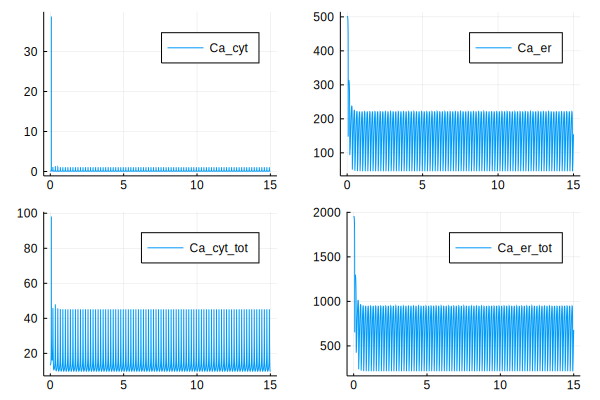

In [6]:
p1 = plot(output[:t]/60,output[:Ca_cyt],label="Ca_cyt")
p3 = plot(output[:t]/60,output[:other_Ca_cyt_tot],label="Ca_cyt_tot")

p2 = plot(output[:t]/60,output[:Ca_er],label="Ca_er")
p4 = plot(output[:t]/60,output[:other_Ca_er_tot],label="Ca_er_tot")

plot(p1,p2,p3,p4)

In [97]:
p_range=[[0.1,10],[0.1,10],[0.1,10],[0.4,1.2],[0.5,2]]
rd= give_rand_p_new(p_range)
t = collect(range(0, stop=60*15, length=120))
getf_new(rd,q0_elevated,s0_elevated,t) 

18×120 Array{Float64,2}:
    3.3199e-5      0.000269773  …       0.000381619       0.000381619
    0.00738113     0.0587671            0.0848565         0.0848565  
  118.513        118.247              117.467           117.467      
    0.747518       0.689419             0.668621          0.668621   
    0.0048209      0.0347414            0.0473894         0.0473894  
    0.243054       0.242231     …       0.238842          0.238842   
    0.00327284     0.00344532           0.00334704        0.00334704 
    5.84407e-6     6.29652e-6           6.0442e-6         6.0442e-6  
    0.00177561     0.00181688           0.00179552        0.00179552 
    0.0186988      0.0224259            0.0192856         0.0192856  
    0.0141832      0.0192429    …       0.0146874         0.0146874  
    0.060612       0.0718872            0.0624549         0.0624549  
    0.1            0.102341             0.101132          0.101132   
  500.0          127.546               66.0234           66.0234 

In [98]:
rd = [1 1 1 1]       
s_r = reconstruct(s0_elevated, Ca_mit = rd[4]*0.25)
        if length(rd)>4
            q_r= reconstruct(q0_elevated, L=rd[5]*0.4)
        else
            q_r =q0_elevated
        end
        test1 = ODEs(s_r,0,q_r,fix=["Ca_mit","Ca_ecs"])
        sdict1 = type2dict(s_r)
        ode_vars1 = keys(test1);
        u1 = broadcast(v->sdict1[Symbol(v)], ode_vars1)
        function ode_problem_fun_r(du,u,p,t)
            ydict = Dict(Symbol(k)=>v for (k,v) in zip(ode_vars1,u))
            ydot = ODEs(reconstruct(s_r,ydict),t,q_r,fix=fix,rd_cer=rd[1],rd_cmi=rd[2],rd_ces=rd[3])
            for (j,v) in enumerate(ode_vars1)
                du[j] = ydot[v]
            end
            return du
        end
    timespan = (t[1],t[end]);
    fix=["Ca_mit","Ca_ecs"]
    prob1 = ODEProblem(ode_problem_fun_r,u1,timespan)
   

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 900.0)
u0: [3.3199e-5, 0.00738113, 118.513, 0.747518, 0.0048209, 0.243054, 0.00327284, 5.84407e-6, 0.00177561, 0.0186988, 0.0141832, 0.060612, 0.1, 500.0, 1300.0, 0.25, 0.0, 0.0]

In [7]:
N=100
using JLD
p_range=[[0.1,10],[0.1,10],[0.1,10],[0.4,1.2],[0.5,2]]
rd = give_rand_p_new(p_range)
t = collect(range(0, stop=60*15, length=100))
y0,v = calc_mean_var_new(q0_elevated,s0_elevated,t,p_range,N)


([3.3199e-5 0.000180611 … 0.000231158 0.000231158; 0.00738113 0.0798741 … 0.0592808 0.0612788; … ; 0.0 63.496 … 1586.28 1601.78; 0.0 49.1788 … -19983.5 -20194.3], [3.92911e-24 3.6486e-9 … 6.57448e-9 6.57448e-9; 1.55854e-19 0.00274723 … 0.00107149 0.00106433; … ; 0.0 1920.57 … 4.2612e6 4.34806e6; 0.0 1.2275e5 … 7.93602e8 8.10223e8])

In [8]:
save("y0_data_sen1h_fastncx.jld", "data", y0)
save("v_data_sen1h_fastncx.jld", "data", v)

In [9]:
fs = first_order_var_new(q0_elevated,s0_elevated,t,p_range,N,y0);
save("fs_data_sen1h_fastncx.jld", "data", fs)

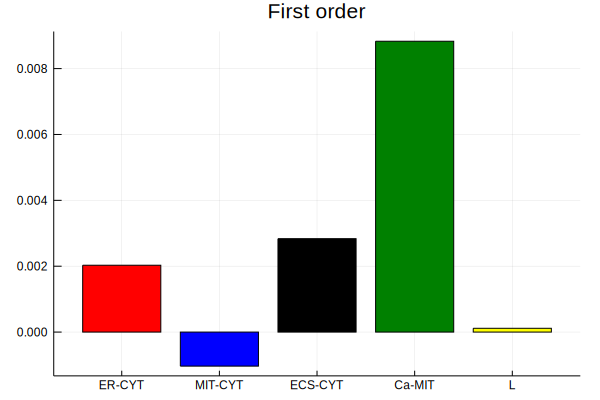

In [10]:
p1 = bar(["ER-CYT","MIT-CYT","ECS-CYT","Ca-MIT","L"],[fs[1][end-2],fs[2][end-2],fs[3][end-2],fs[4][end-2],fs[5][end-2]],color=[:red,:blue,:black,:green,:yellow],title="First order",legend=false)
plot(p1)

In [ ]:
ss = second_order_var_new(q0_elevated,s0_elevated,t,p_range,N,y0);
save("ss_data_sen1h_fastncx.jld", "data", ss)